In [1]:
# 导入所有需要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score
from scipy.stats import ks_2samp
from sklearn.decomposition import PCA
import warnings
import os

# 创建图片保存目录
os.makedirs('../docs/images', exist_ok=True)

# 设置一些美观的绘图风格
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.sans-serif'] = ['SimHei']  # 支持中文显示
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 忽略一些不重要的警告
warnings.filterwarnings('ignore')

print("Libraries imported and environment set!")
print(f"Images will be saved to: {os.path.abspath('../docs/images')}")


Libraries imported and environment set!
Images will be saved to: d:\AAI-HDTL-Transfer-High-Dimensional-Tabular-Learning-with-Cross-Domain-Transfer-main\docs\images


In [2]:
# 定义文件路径
TRAIN_PATH = '../data/train.csv'
TEST_IN_DOMAIN_PATH = '../data/test_in_domain.csv'
TEST_CROSS_DOMAIN_PATH = '../data/test_cross_domain.csv'

# 加载数据
train_df = pd.read_csv(TRAIN_PATH)
test_in_df = pd.read_csv(TEST_IN_DOMAIN_PATH)
test_cross_df = pd.read_csv(TEST_CROSS_DOMAIN_PATH)

# --- 基础信息检查 ---
print("--- Data Loaded & Basic Info ---")
print(f"Training data shape: {train_df.shape}")
print(f"In-domain test data shape: {test_in_df.shape}")
print(f"Cross-domain test data shape: {test_cross_df.shape}")

# 检查列名
print("\nColumn names in training set:")
print(train_df.columns.tolist())

# 检查数据类型
print("\nData types in training set:")
print(train_df.dtypes.value_counts())

# 检查缺失值
missing_values = train_df.isnull().sum()
print(f"\nNumber of features with missing values in training set: {(missing_values > 0).sum()}")

# 检查标签列 - 假设最后一列是标签列
label_col = train_df.columns[-1]
print(f"\nLabel column name: '{label_col}'")
label_counts = train_df[label_col].value_counts(normalize=True)
print("\nLabel distribution in training set:")
print(label_counts)

print("\nFirst 5 rows of training data:")
display(train_df.head())


--- Data Loaded & Basic Info ---
Training data shape: (196, 12701)
In-domain test data shape: (84, 12700)
Cross-domain test data shape: (200, 12700)

Column names in training set:
['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116',

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f12692,f12693,f12694,f12695,f12696,f12697,f12698,f12699,f12700,label
0,2.008869,0.661586,-0.881317,-1.346921,6.308250,0.949533,0.809938,-0.270223,0.550717,-1.675216,...,0.374400,2.109813,2.941201,-2.822833,-1.708363,1.533172,-0.358759,-1.700250,0.126823,1
1,2.117962,0.472476,-1.186320,-1.611358,5.792537,0.882704,2.109983,-0.332148,0.348025,-2.549607,...,0.184472,2.735963,2.186440,-2.060650,-1.712021,1.444733,-0.125485,-0.853564,-1.159878,1
2,2.174916,-2.493834,-0.978814,-1.593388,6.834124,0.984523,2.038460,-0.267896,0.441295,-1.888380,...,0.560309,3.456544,2.109844,-1.833836,-0.517322,1.693220,-0.256862,-0.859434,-1.036194,1
3,1.960041,0.221588,-0.930629,-1.067503,5.669284,0.977464,1.737995,-0.296710,0.633400,-2.277830,...,0.329226,6.534231,2.024624,-0.875080,-2.420477,1.553472,0.134826,-0.734175,-1.270694,0
4,1.768257,-2.799747,-1.204840,-1.976151,6.613207,0.991079,2.286262,-0.476403,0.474687,-1.950455,...,0.638272,6.569954,2.607458,-1.431556,-1.527168,1.242612,0.534312,-0.124918,-1.301821,1


Dataset characteristics: 196 samples, 12700 features
High-dimensional data: Features >> Samples ratio = 64.8


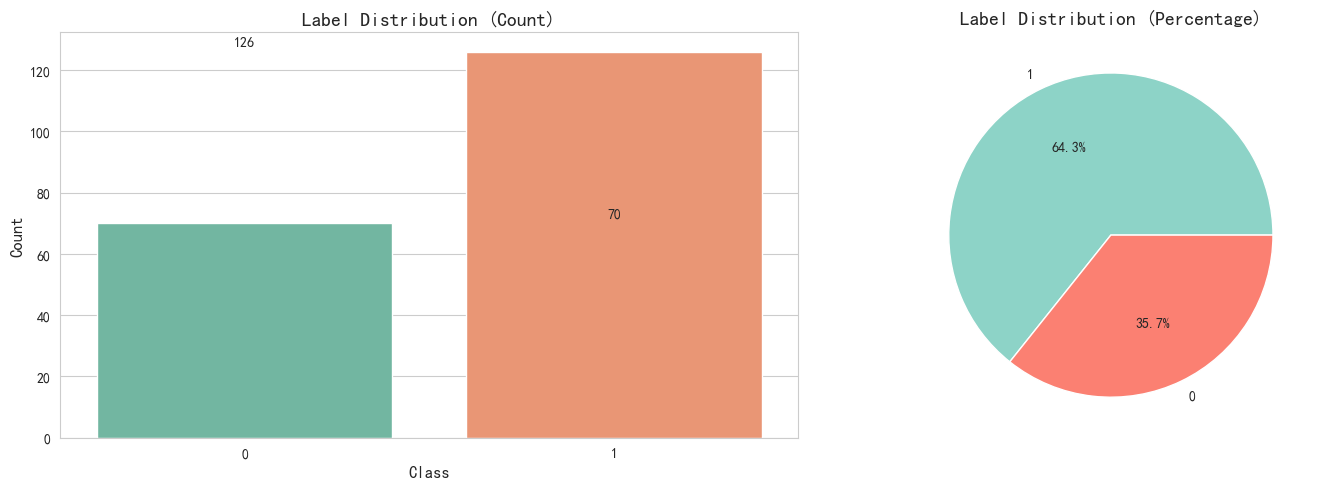


FEATURE VARIANCE ANALYSIS
Features with variance = 0: 0
Features with variance < 0.01: 531
Features with variance < 0.1: 7378


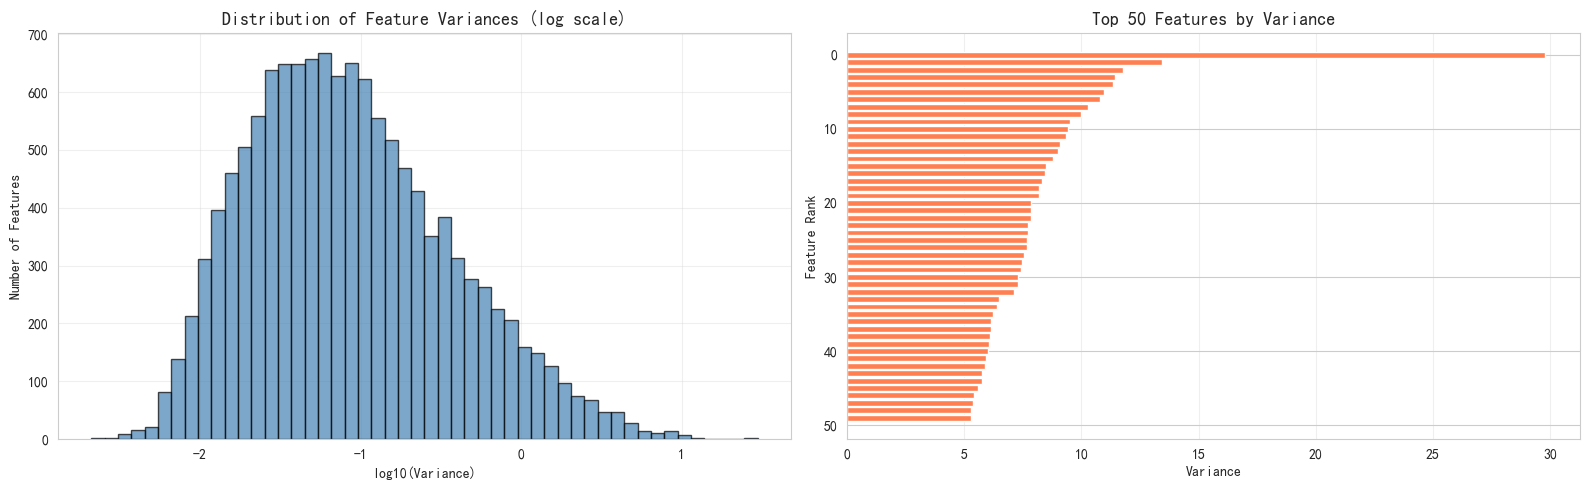


FEATURE-LABEL CORRELATION ANALYSIS

Top 20 features most correlated with label:
f11394    0.320097
f6044     0.310549
f11105    0.307812
f8339     0.303670
f1432     0.299213
f9618     0.296225
f11613    0.296079
f8628     0.294190
f11451    0.291818
f11488    0.286041
f12528    0.285481
f4018     0.284169
f4010     0.284030
f411      0.282094
f10446    0.281961
f921      0.281378
f5883     0.279666
f11983    0.279578
f8436     0.279415
f1179     0.279062
dtype: float64


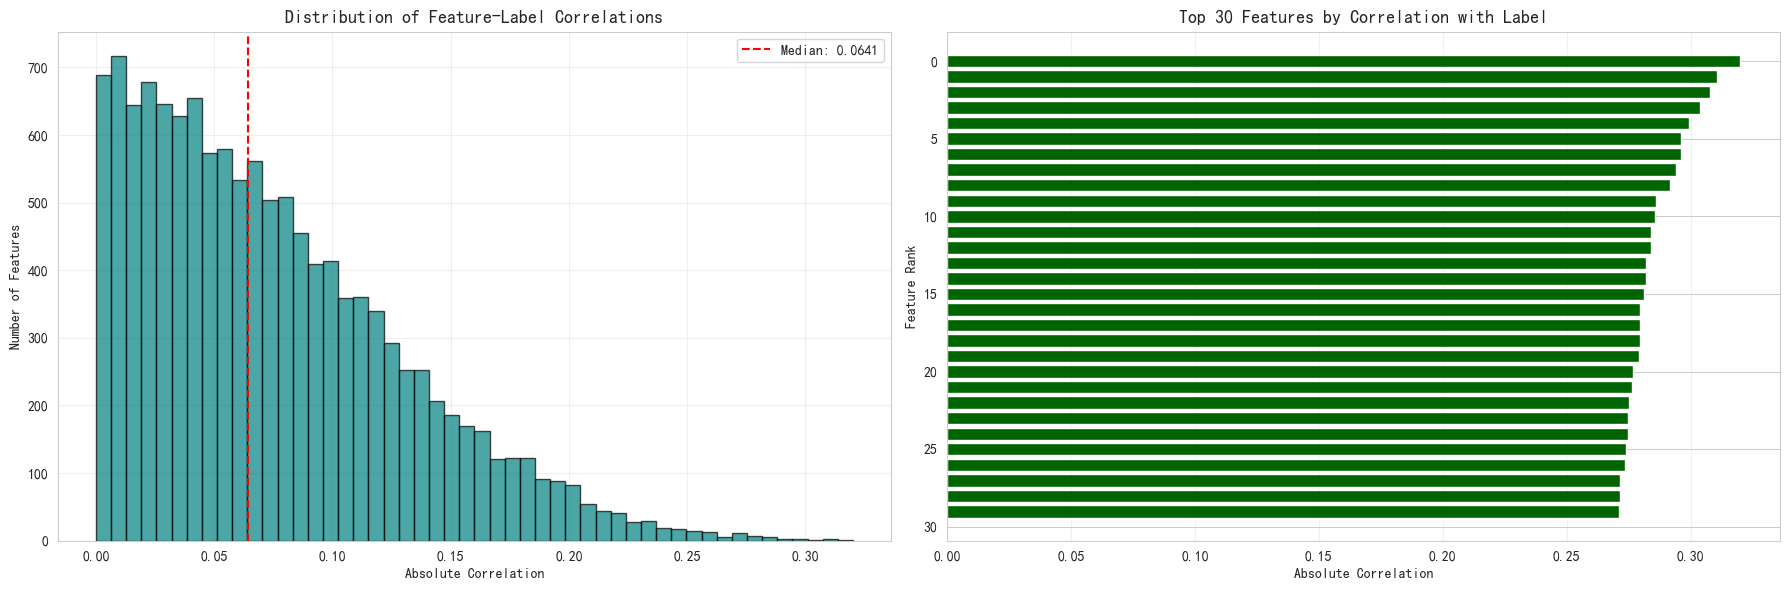


DISTRIBUTION OF TOP CORRELATED FEATURES


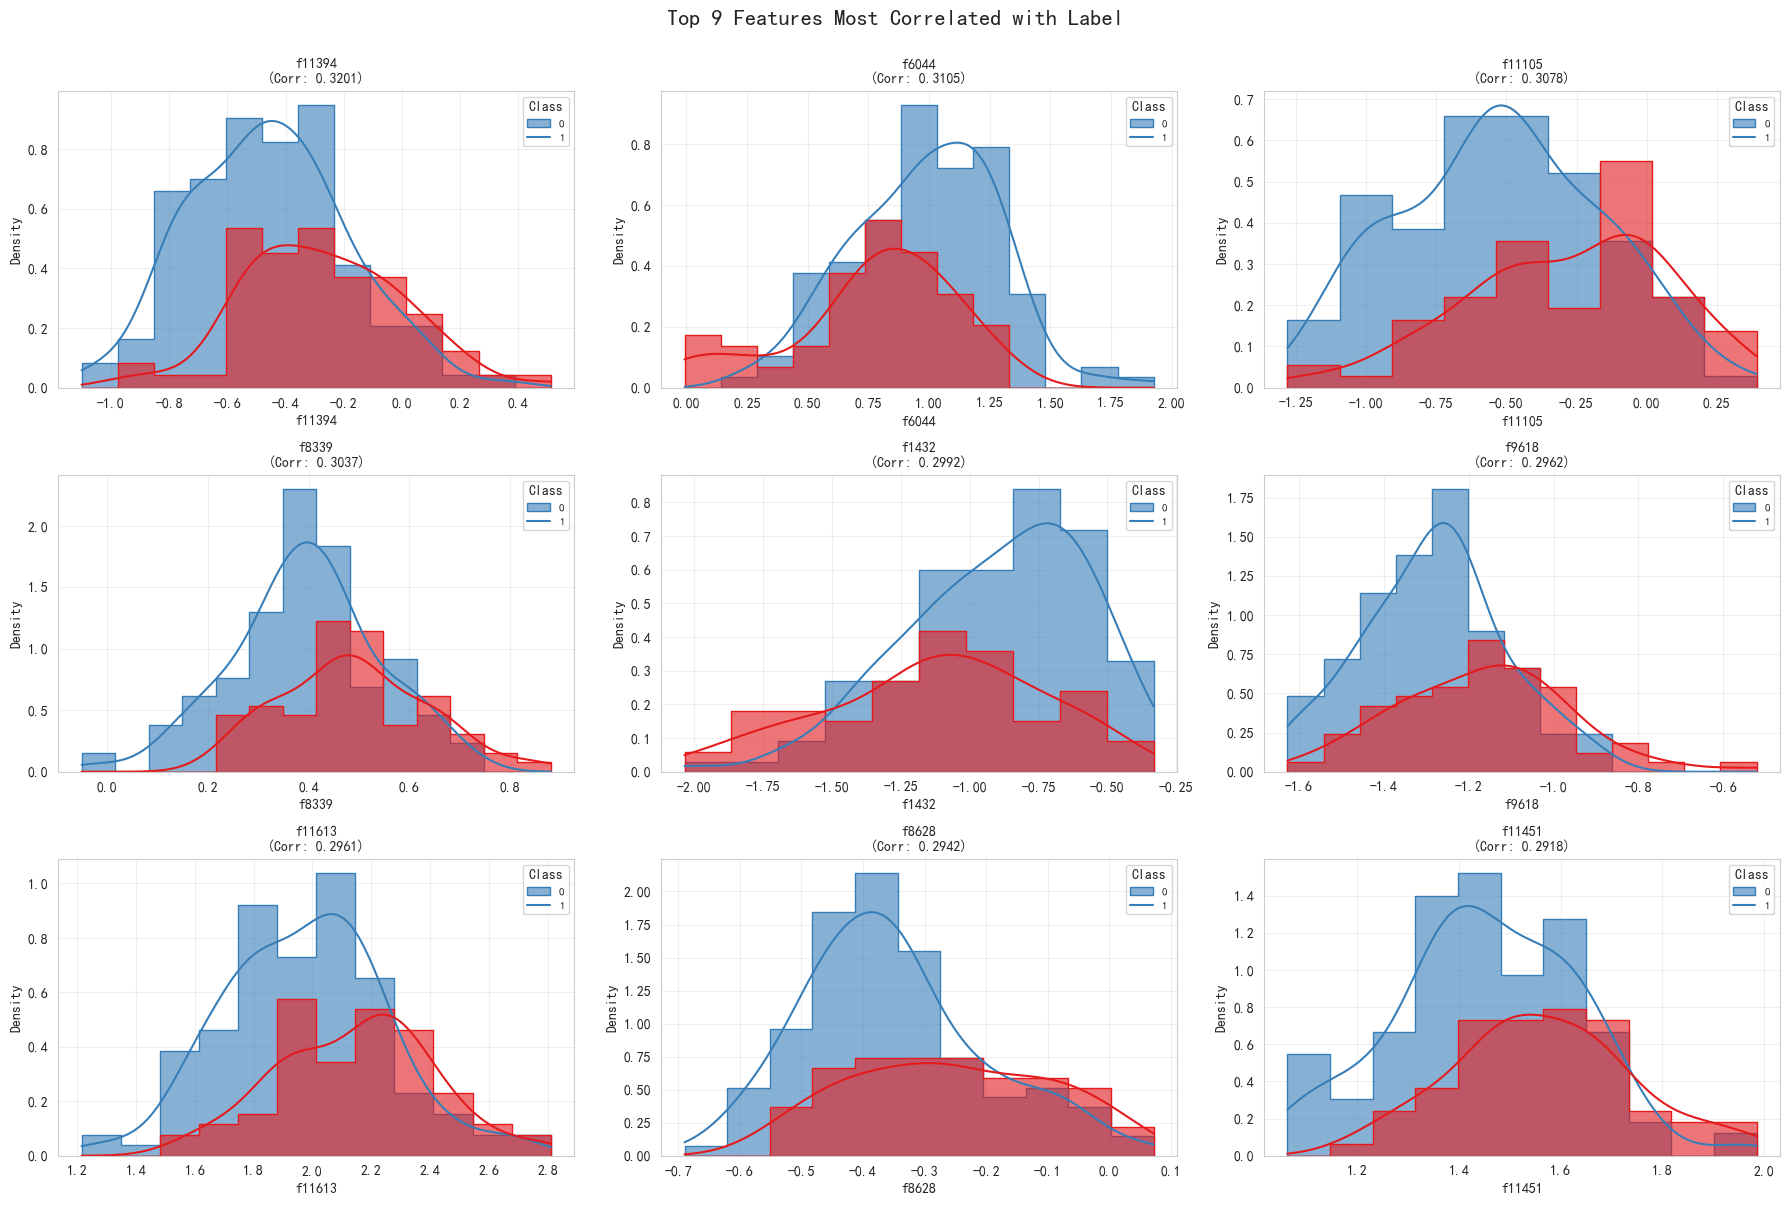

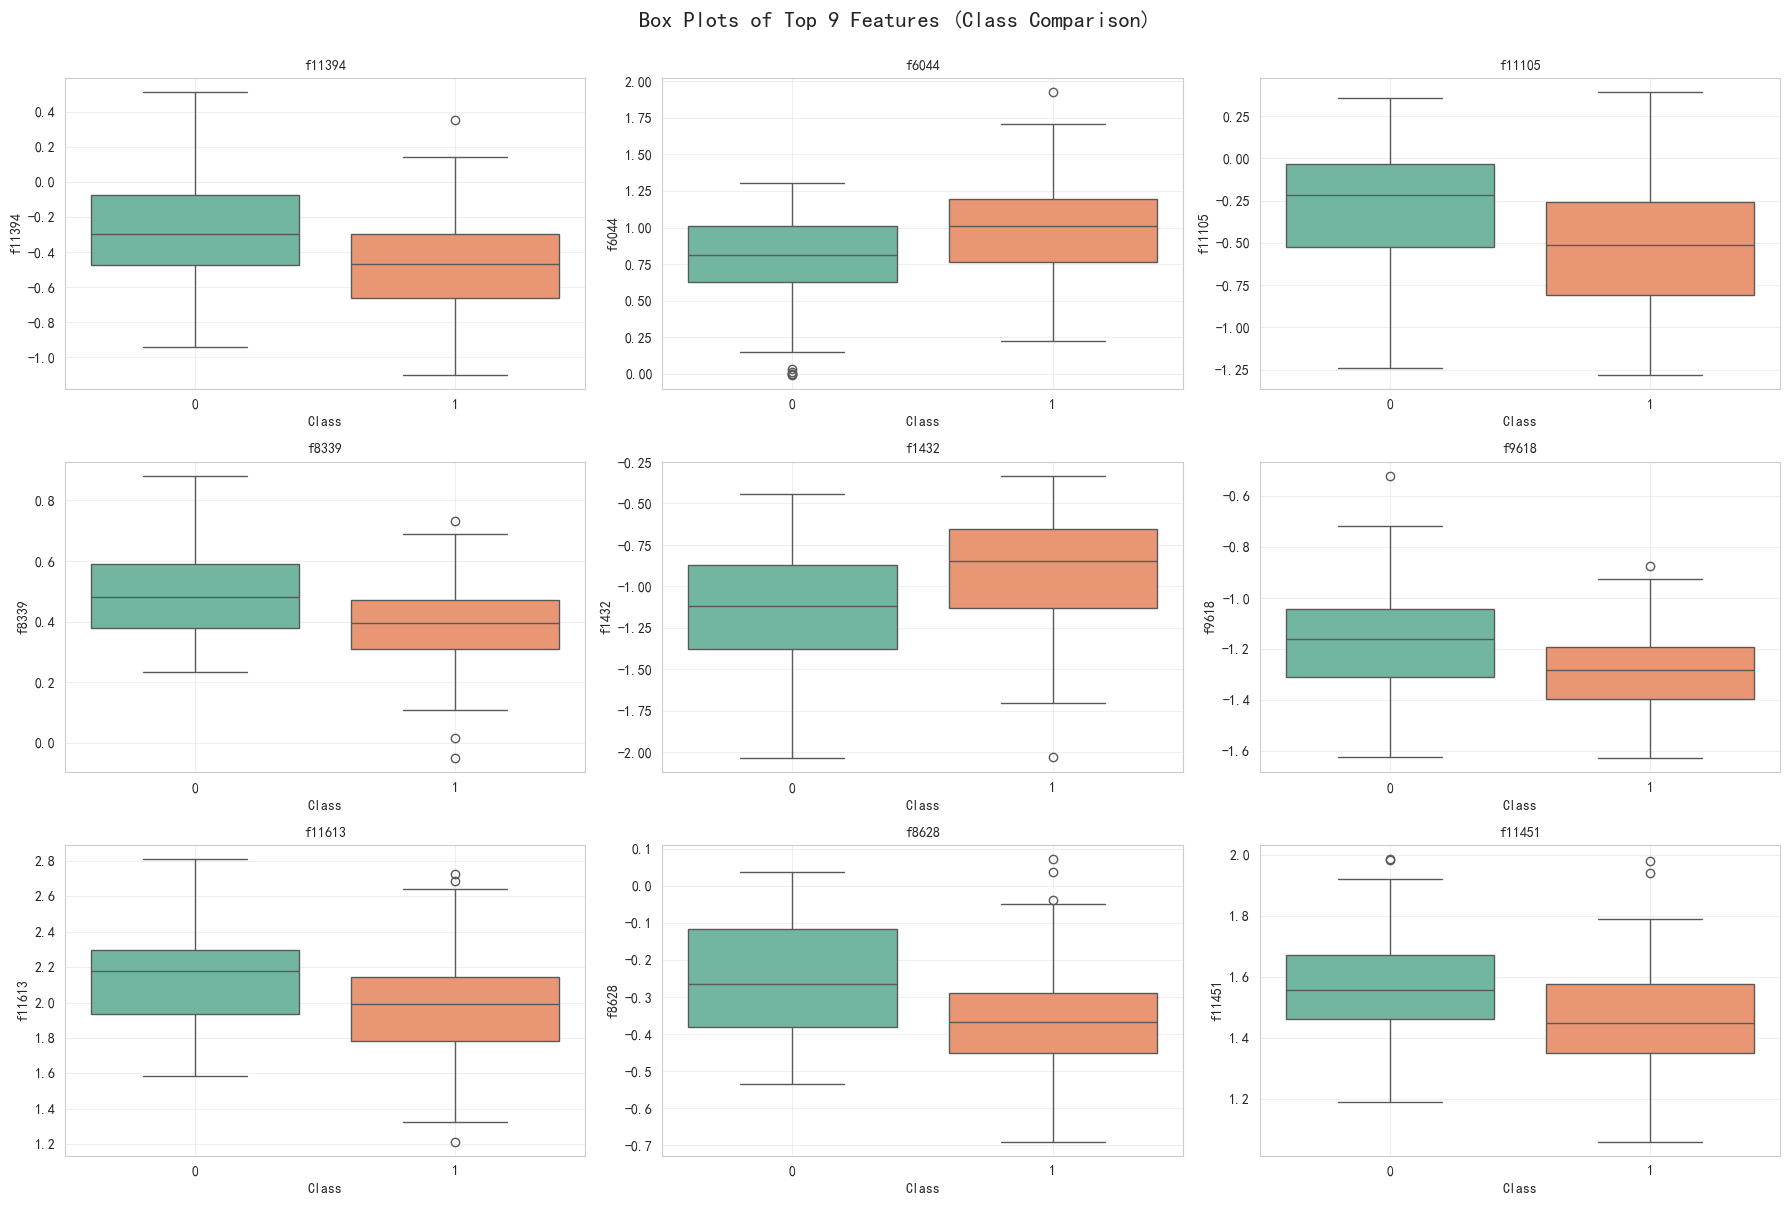


PCA DIMENSIONALITY REDUCTION
Variance explained by first 10 PCs: 0.3448
Variance explained by first 50 PCs: 0.5967


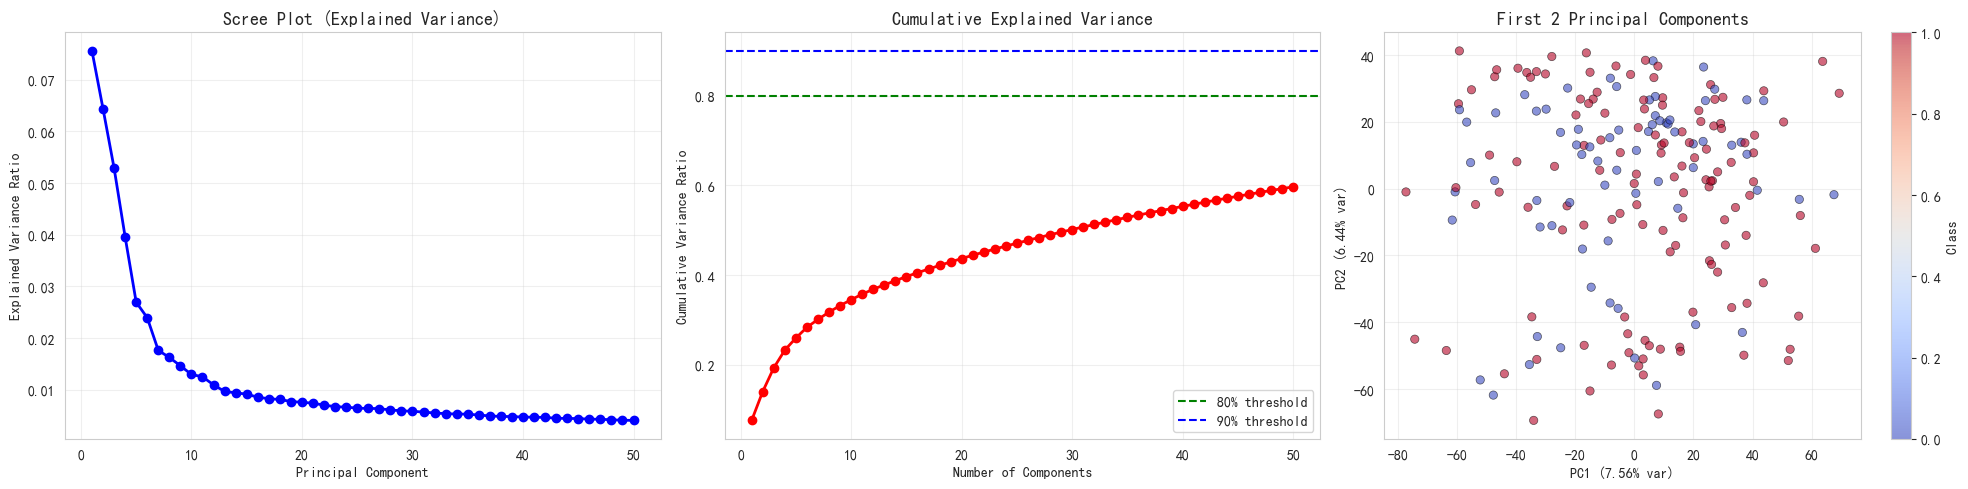


SUMMARY STATISTICS
Total features: 12700
Features with zero variance: 0
Features with correlation > 0.1: 3657
Features with correlation > 0.2: 365
Features with correlation > 0.3: 4

✓ All visualizations saved to ../docs/images/


In [3]:
# 获取标签列名和特征列
label_col = train_df.columns[-1]
feature_cols = train_df.columns[:-1]
n_features = len(feature_cols)
n_samples = len(train_df)

print(f"Dataset characteristics: {n_samples} samples, {n_features} features")
print(f"High-dimensional data: Features >> Samples ratio = {n_features/n_samples:.1f}")

# --- 1. 标签分布可视化 ---
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 计数图
label_counts = train_df[label_col].value_counts()
sns.countplot(x=label_col, data=train_df, ax=axes[0], palette='Set2')
axes[0].set_title('Label Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
for i, v in enumerate(label_counts):
    axes[0].text(i, v + 2, str(v), ha='center', fontweight='bold')

# 饼图
label_counts.plot(kind='pie', ax=axes[1], autopct='%1.1f%%', colors=['#8dd3c7', '#fb8072'])
axes[1].set_title('Label Distribution (Percentage)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.savefig('../docs/images/01_label_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# --- 2. 特征方差分析(识别低方差特征) ---
print("\n" + "="*80)
print("FEATURE VARIANCE ANALYSIS")
print("="*80)
feature_vars = train_df[feature_cols].var().sort_values(ascending=False)
print(f"Features with variance = 0: {(feature_vars == 0).sum()}")
print(f"Features with variance < 0.01: {(feature_vars < 0.01).sum()}")
print(f"Features with variance < 0.1: {(feature_vars < 0.1).sum()}")

# 可视化方差分布
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# 方差分布直方图
axes[0].hist(np.log10(feature_vars + 1e-10), bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Feature Variances (log scale)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('log10(Variance)')
axes[0].set_ylabel('Number of Features')
axes[0].grid(True, alpha=0.3)

# Top 50 高方差特征
top_50_vars = feature_vars.head(50)
axes[1].barh(range(len(top_50_vars)), top_50_vars.values, color='coral')
axes[1].set_title('Top 50 Features by Variance', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Variance')
axes[1].set_ylabel('Feature Rank')
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../docs/images/02_feature_variance.png', dpi=300, bbox_inches='tight')
plt.show()

# --- 3. 特征与标签的相关性分析 ---
print("\n" + "="*80)
print("FEATURE-LABEL CORRELATION ANALYSIS")
print("="*80)

# 计算相关性
label_corr = train_df[feature_cols].corrwith(train_df[label_col]).abs().sort_values(ascending=False)
print(f"\nTop 20 features most correlated with label:")
print(label_corr.head(20))

# 可视化
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 相关性分布
axes[0].hist(label_corr.values, bins=50, color='teal', edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Feature-Label Correlations', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Absolute Correlation')
axes[0].set_ylabel('Number of Features')
axes[0].axvline(label_corr.median(), color='red', linestyle='--', label=f'Median: {label_corr.median():.4f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Top 30 相关特征
top_30_corr = label_corr.head(30)
axes[1].barh(range(len(top_30_corr)), top_30_corr.values, color='darkgreen')
axes[1].set_title('Top 30 Features by Correlation with Label', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Absolute Correlation')
axes[1].set_ylabel('Feature Rank')
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../docs/images/03_feature_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

# --- 4. 高相关特征的分布对比 ---
print("\n" + "="*80)
print("DISTRIBUTION OF TOP CORRELATED FEATURES")
print("="*80)

# 选择Top 9个最相关的特征
top_features = label_corr.head(9).index

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
axes = axes.ravel()

for i, feature in enumerate(top_features):
    # 直方图
    sns.histplot(data=train_df, x=feature, hue=label_col, kde=True, 
                 ax=axes[i], element='step', palette='Set1', alpha=0.6, stat='density')
    axes[i].set_title(f'{feature}\n(Corr: {label_corr[feature]:.4f})', 
                     fontsize=10, fontweight='bold')
    axes[i].legend(title='Class', labels=['0', '1'], fontsize=8)
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Top 9 Features Most Correlated with Label', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('../docs/images/04_top_features_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# --- 5. 箱线图:Top特征的类别差异 ---
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
axes = axes.ravel()

for i, feature in enumerate(top_features):
    sns.boxplot(data=train_df, x=label_col, y=feature, ax=axes[i], palette='Set2')
    axes[i].set_title(f'{feature}', fontsize=10, fontweight='bold')
    axes[i].set_xlabel('Class')
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Box Plots of Top 9 Features (Class Comparison)', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('../docs/images/05_top_features_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

# --- 6. PCA降维可视化 ---
print("\n" + "="*80)
print("PCA DIMENSIONALITY REDUCTION")
print("="*80)

# 标准化数据
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_df[feature_cols])

# PCA降维
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_scaled)

# 解释方差
cumsum_var = np.cumsum(pca.explained_variance_ratio_)
print(f"Variance explained by first 10 PCs: {cumsum_var[9]:.4f}")
print(f"Variance explained by first 50 PCs: {cumsum_var[49]:.4f}")

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# 碎石图
axes[0].plot(range(1, 51), pca.explained_variance_ratio_, 'bo-', linewidth=2)
axes[0].set_title('Scree Plot (Explained Variance)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].grid(True, alpha=0.3)

# 累积解释方差
axes[1].plot(range(1, 51), cumsum_var, 'ro-', linewidth=2)
axes[1].axhline(y=0.8, color='g', linestyle='--', label='80% threshold')
axes[1].axhline(y=0.9, color='b', linestyle='--', label='90% threshold')
axes[1].set_title('Cumulative Explained Variance', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Variance Ratio')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# PCA前两个主成分的散点图
scatter = axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c=train_df[label_col], 
                          cmap='coolwarm', alpha=0.6, edgecolors='k', linewidth=0.5)
axes[2].set_title('First 2 Principal Components', fontsize=13, fontweight='bold')
axes[2].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} var)')
axes[2].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} var)')
axes[2].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[2], label='Class')

plt.tight_layout()
plt.savefig('../docs/images/06_pca_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# --- 7. 特征统计摘要 ---
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"Total features: {n_features}")
print(f"Features with zero variance: {(feature_vars == 0).sum()}")
print(f"Features with correlation > 0.1: {(label_corr > 0.1).sum()}")
print(f"Features with correlation > 0.2: {(label_corr > 0.2).sum()}")
print(f"Features with correlation > 0.3: {(label_corr > 0.3).sum()}")

print("\n✓ All visualizations saved to ../docs/images/")
